#Ensemble Kalman filter
The code is not yet completed, it has some overflow issue

In [181]:
# import all the required packages
import numpy as np
import matplotlib.pyplot as plt

In [116]:
## functions defined
# process equation:
def f(x,u):
    tol = 1e-10
    dt = 0.01
    x = rk45(x,u,dt,tol)

    return x

# measurement equation:
def g(x,u):
    m = 1
    k = 100
    c = 0.01
    C = np.array([-k/m,-c/m])
    D = np.array([1])
    y = C@x + D*u

    return y

# runga-kutta combined 4th and 5th order solver
def rk45(x,u,dt,tol):
    x1 = rk4(x,u,dt)
    x2 = rk5(x,u,dt)
    itr = 1
    h = dt

    while abs(x1-x2).all() > tol/itr:
        itr = itr + 1
        h = dt/itr
        x1 = rk4(x,u,h)
        x2 = rk5(x,u,h)
    
    for i in range(itr):
        x = rk5(x,u,h)

    return x 

# runga-kutta 4th order solver
def rk4(x,u,dt):
    k1 = ss_model(x,u)
    k2 = ss_model(x+dt/2*k1,u)
    k3 = ss_model(x+dt/2*k2,u)
    k4 = ss_model(x+dt*k3,u)
    x = x + dt/6*(k1+2*k2+2*k3+k4)
    return x

# runga-kutta 5th order solver
def rk5(x,u,dt):
    k1 = ss_model(x,u)
    k2 = ss_model(x+dt/4*k1,u)    
    k3 = ss_model(x+dt/8*k1+dt/8*k2,u) 
    k4 = ss_model(x-dt/2*k2+dt*k3,u)
    k5 = ss_model(x+3/16*dt*k1+9/16*dt*k4,u)
    k6 = ss_model(x-3/7*dt*k1+2/7*dt*k2+12/7*dt*k3-12/7*dt*k4+8/7*dt*k5,u)
    x = x + dt/90*(7*k1+32*k3+12*k4+32*k5+7*k6)

    return x

# state-space model
def ss_model(x,u):
    m = 1
    k = 100
    c = 0.01
    duffing_k = 100
    x_derivative = np.array([[x[1][0]],[-k/m*x[0][0]-c/m*x[1][0]+u/m-duffing_k*x[0][0]/m]])

    return x_derivative

In [190]:
# measurement data generation
u_store = np.zeros(1000)
y_meas = np.zeros((1000,1))
x = np.array([[0.0],[0]])
for i in range(1000):
    # u = np.random.randn()
    u = 0
    x = f(x,u)
    y = g(x,u)

    u_store[i] = u
    y_meas[i] = y[0]

In [170]:
u

0

In [191]:
T = 10 # 10 seconds
freq = 100 # sampling frequency
dt = 1/freq
t = np.linspace(0,10,1001,endpoint=True)

n = 2 # size of state x
m = 1 # size of measurement y
q = 100 # number of samples in EnKF

Q = np.diag([0.001,0.01])
R = np.diag([0.01])
Q_chol = np.linalg.cholesky(Q)
R_chol = np.linalg.cholesky(R)

x_store = np.zeros((n,1001))
y_store = np.zeros((m,1001))
x_sigma_store = np.zeros((n,1001))
y_sigma_store = np.zeros((m,1001))
x_samples = np.zeros((n,q))
y_samples = np.zeros((m,q))

# initialize
x = np.array([[0.0],[0.]])
x_samples = x + Q_chol@np.random.randn(n,q)

x_store[:,0] = x[:,0]
x_sigma_store[:,0] = np.diag(Q_chol)
for i in range(1000):
    u = u_store[i]
    y_meas = y_store[:,i]

    # prediction/forecast step
    for j in range(q):
        x_samples[:,j] = f(np.reshape(x_samples[:,j],(n,1)),u)[:,0]

    x_mean = np.reshape(np.mean(x_samples,1),(n,1))

    E_xx = x_samples - x_mean     
    # P_xx = 1/(q-1)*E_xx@E_xx.T # here there is no need to predict covarinace P

    # update/analysis step
    for j in range(q):
        y_samples[:,j] = g(np.reshape(x_samples[:,j],(n,1)),u)
    y_meas_samples = y_meas + R_chol@np.random.randn(m,q)
    y_meas_mean = np.mean(y_meas_samples)

    E_yy = y_meas_samples - y_meas_mean
    P_yy = 1/(q-1)*E_yy@E_yy.T
    P_xy = 1/(q-1)*E_xx@E_yy.T

    K = P_xy@np.linalg.inv(P_yy)

    x_samples = x_samples + K@(y_meas_samples-y_samples)
    x_mean = np.reshape(np.mean(x_samples,1),(n,1))

    E_xx = x_samples - x_mean
    P_xx = 1/(q-1)*E_xx@E_xx.T

    x_store[:,i+1] = x_mean[:,0]
    x_sigma_store[:,i+1] = np.diag(P_xx)**0.5
    

C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2352929192.py:57: RuntimeWarning: overflow encountered in matmul
  P_xx = 1/(q-1)*E_xx@E_xx.T
C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2352929192.py:53: RuntimeWarning: overflow encountered in matmul
  x_samples = x_samples + K@(y_meas_samples-y_samples)
C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2186202057.py:66: RuntimeWarning: invalid value encountered in scalar subtract
  x_derivative = np.array([[x[1][0]],[-k/m*x[0][0]-c/m*x[1][0]+u/m-duffing_k*x[0][0]/m]])
C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2186202057.py:42: RuntimeWarning: invalid value encountered in add
  k2 = ss_model(x+dt/2*k1,u)
C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2186202057.py:51: RuntimeWarning: invalid value encountered in add
  k2 = ss_model(x+dt/4*k1,u)
C:\Users\smicr\AppData\Local\Temp\ipykernel_28512\2186202057.py:52: RuntimeWarning: invalid value encountered in add
  k3 = ss_model(x+dt/8*k1+dt/8*k2,u)
C:\Users\smicr\AppDat

KeyboardInterrupt: 

In [186]:
x_store[0:]+1.96*x_sigma_store[0,:]

array([[0.06198064, 0.41511706, 0.26989505, ..., 0.        , 0.        ,
        0.        ],
       [0.06198064, 0.35554699, 1.18484363, ..., 0.        , 0.        ,
        0.        ]])

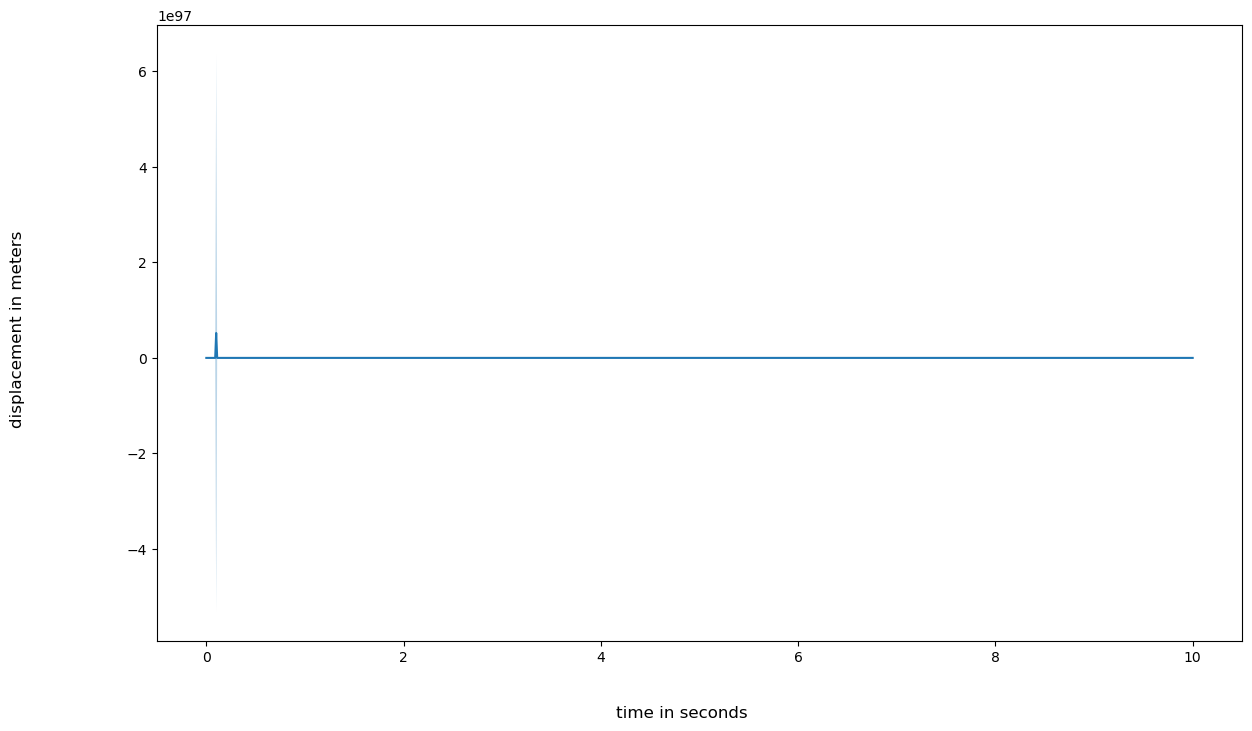

In [187]:
# plots
m = 1 # no of plots
fig = plt.figure(figsize=(14,8), dpi=100)
for j in range(m):
    plt.fill_between(t, x_store[0,:]-1.96*x_sigma_store[0,:], x_store[0,:]+1.96*x_sigma_store[0,:], alpha=0.3)
    plt.plot(t,x_store[0,:])
    # plt.plot(t,mat02[100*j:100*(j+1),0],'r*',markersize=2)
fig.supxlabel('time in seconds')
fig.supylabel('displacement in meters')
plt.show()
